In [1]:
import matplotlib.pyplot as plt

import sys
sys.path.append('../../default_settings')
from default_settings import mpl_figure_settings
mpl_figure_settings.set_params(plt)

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Dataset

In [2]:
import os
import numpy as np
from PIL import Image

import torch

## Penn Customized Dataset

target: a dict containing the following fields
- `boxes` (FloatTensor[N, 4]): the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H
- `labels` (Int64Tensor[N]): the label for each bounding box. 0 represents always the background class.
- `image_id` (Int64Tensor[1]): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
- `area` (Tensor[N]): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
- `iscrowd` (UInt8Tensor[N]): instances with iscrowd=True will be ignored during evaluation.
- (optionally) `masks` (UInt8Tensor[N, H, W]): The segmentation masks for each one of the objects
- (optionally) `keypoints` (FloatTensor[N, K, 3]): For each one of the N objects, it contains the K keypoints in [x, y, visibility] format, defining the object. visibility=0 means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt references/detection/transforms.py for your new keypoint representation

In [3]:
class PennFudanDataset(torch.utils.data.Dataset):
    """Dataset PennFudan

    Attributes:
        root: A string of dataset root
        transforms: transform for dataset
    """

    def __init__(self, root, transforms):
        """Initializes the variables related to dataset

        Args:
            root: A string of dataset root
            transforms: transform for dataset
        """
        super().__init__()
        self.root = root                                        # file root
        self.transforms = transforms                            # dataset transforms

        self.img_dir = os.path.join(root, "PNGImages")          # image dir
        self.mask_dir = os.path.join(root, "PedMasks")          # mask dir

        self.imgs = list(sorted(os.listdir(self.img_dir)))      # img names
        self.masks = list(sorted(os.listdir(self.mask_dir)))    # masks names

    def __getitem__(self, index):
        """Get one sample from dataset"""
        image_path = os.path.join(self.root, "PNGImages", self.imgs[index])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[index])

        img = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)

        obj_ids = np.unique(mask)              # unique ids for each object
        obj_ids = obj_ids[1: ]                 # get rid of background color

        masks = mask==obj_ids[:, None, None]   # binary mask


        # get bounding box coordinates
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)                 # boxes of each object
        labels = torch.ones((num_objs, ), dtype=torch.int64)                # labels of each object
        masks = torch.as_tensor(masks, dtype=torch.uint8)                   # masks for each target
        image_id = torch.tensor([index])                                    # image id
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])    # area size
        iscrowd = torch.zeros((num_objs, ), dtype=torch.int64)             # instances with iscrowd=True will be ignored during evaluation.

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        """The size of the dataset"""
        return len(self.imgs)

a demo of masks / obj_ids
```python
import numpy as np

mask = np.array([[0, 0, 1, 1],
                 [0, 2, 2, 0],
                 [3, 3, 0, 0]])

obj_ids = np.unique(mask)[1:]
print(obj_ids[:, None, None])
# [[[1]]
#  [[2]]
#  [[3]]]

masks = mask == obj_ids[:, None, None]  # broadcast in numpy
print(masks)
# [[[False False  True  True]
#   [False False False False]
#   [False False False False]]
#  [[False False False False]
#   [False  True  True False]
#   [False False False False]]
#  [[False False False False]
#   [False False False False]
#   [ True  True False False]]]
```

## Define the Model

modify the model in two ways:
- finetuning
- change teh backbone

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

### finetuning from a pretrained model

In [5]:
# replace the classifier
num_classes = 2    # background + person
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### Modifying the model to add a different backbone

In [6]:
# add a different backbone
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# backbone net
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
backbone.out_channels = 1280

# anchor box generator
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512), ),
                                   aspect_ratios=((0.5, 1.0, 2.0), ))
# ROI Pooling
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)


[AnchorGenerator](https://tanalib.com/faster-rcnn-anchor/)
[Faster RCNN Source Code](https://zhuanlan.zhihu.com/p/145842317)
[ROI Pooling & ROI Align](https://zhuanlan.zhihu.com/p/73138740)


In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    """compute the instance segmentation masks using Mask RCNN"""
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

## Put Everything Together

In [8]:
from references.detection import transforms as T

def get_transform(train):
    """transform for PennFudan Dataset"""
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ToDtype(torch.float, scale=True))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

## Testing `forward()` method

[{'boxes': tensor([[1.3075e+01, 2.7679e+02, 3.4866e+01, 3.0000e+02],
          [9.7730e+00, 2.7958e+02, 4.4911e+01, 2.9479e+02],
          [3.6973e+02, 3.8333e+00, 3.9979e+02, 2.1504e+01],
          [2.2433e+02, 6.1693e+00, 2.5895e+02, 2.2222e+01],
          [1.1116e+01, 1.7781e+01, 4.4968e+01, 3.2407e+01],
          [3.6731e+02, 0.0000e+00, 3.9988e+02, 6.3222e+01],
          [1.1947e-01, 5.1521e-02, 5.9860e+01, 3.5845e+01],
          [2.3727e+02, 5.8351e+00, 2.7212e+02, 2.1557e+01],
          [2.0142e+02, 5.3618e+00, 2.3445e+02, 2.1978e+01],
          [0.0000e+00, 2.7179e+02, 4.1099e+01, 3.0000e+02],
          [3.8275e+02, 1.5244e+01, 3.9994e+02, 3.1314e+01],
          [1.5268e+02, 2.7929e+02, 1.8610e+02, 2.9709e+02],
          [2.1292e+02, 5.4143e+00, 2.4680e+02, 2.1938e+01],
          [1.4508e+02, 2.7726e+02, 1.6804e+02, 3.0000e+02],
          [2.0335e+02, 4.5108e-03, 2.3598e+02, 7.0490e+00],
          [2.1691e+01, 4.8833e+00, 5.6966e+01, 2.1035e+01],
          [3.7269e+02, 1.1318e+

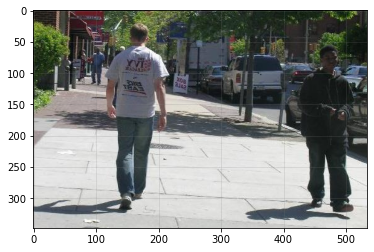

In [17]:
from references.detection import utils

dataset = PennFudanDataset(root=r'PennFudanPed/PennFudanPed',
                           transforms=get_transform(train=True))
dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=2,
                                         shuffle=True,
                                         collate_fn=utils.collate_fn)

# Training
images, targets = next(iter(dataloader))
images = list(image for image in images)

plt.imshow(images[0].permute(1, 2, 0))

targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)

# inference
model.eval()
with torch.inference_mode():
    x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
    predictions = model(x)           # Returns predictions

predictions

## Main Function

In [10]:
from references.detection.engine import train_one_epoch, evaluate
from references.detection import utils

def main():
    # agnostic
    # device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    device = torch.device('cpu')

    # num classes
    num_classes = 2

    # dataset
    training_dataset = PennFudanDataset(root=r'PennFudanPed/PennFudanPed',
                               transforms=get_transform(train=True))
    test_dataset = PennFudanDataset(root=r'PennFudanPed/PennFudanPed',
                               transforms=get_transform(train=True))

    # split training / testing
    indices = torch.randperm(len(dataset)).tolist()
    training_dataset = torch.utils.data.Subset(training_dataset, indices[: -50])
    test_dataset = torch.utils.data.Subset(test_dataset, indices[-50: ])

    # dataloader
    training_dataloader = torch.utils.data.DataLoader(dataset=training_dataset,
                                                      batch_size=2,
                                                      shuffle=True,
                                                      collate_fn=utils.collate_fn)

    test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  collate_fn=utils.collate_fn)

    # get finetuning model
    model = get_model_instance_segmentation(num_classes)
    model.to(device)

    # optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params=params,
                                lr=0.005,
                                momentum=0.9,
                                weight_decay=0.0005)

    # learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # epoches
    num_epochs = 5

    for epoch in range(num_epochs):
        train_one_epoch(model,
                        optimizer,
                        training_dataloader,
                        device,
                        epoch,
                        print_freq=10)
        lr_scheduler.step()
        # evaluate(model,
        #          test_dataloader,
        #          device=device)

    print("OVERR.")

In [11]:
main()

Epoch: [0]  [ 0/60]  eta: 0:18:25  lr: 0.000090  loss: 5.9210 (5.9210)  loss_classifier: 0.4863 (0.4863)  loss_box_reg: 0.4266 (0.4266)  loss_mask: 4.9807 (4.9807)  loss_objectness: 0.0213 (0.0213)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 18.4318  data: 1.0724  max mem: 0
Epoch: [0]  [10/60]  eta: 0:13:17  lr: 0.000936  loss: 1.7297 (3.1976)  loss_classifier: 0.3911 (0.3673)  loss_box_reg: 0.3042 (0.3108)  loss_mask: 1.4153 (2.4876)  loss_objectness: 0.0250 (0.0217)  loss_rpn_box_reg: 0.0078 (0.0102)  time: 15.9595  data: 0.1236  max mem: 0
Epoch: [0]  [20/60]  eta: 0:10:09  lr: 0.001783  loss: 1.0442 (2.0211)  loss_classifier: 0.1915 (0.2560)  loss_box_reg: 0.2530 (0.2523)  loss_mask: 0.4678 (1.4765)  loss_objectness: 0.0295 (0.0264)  loss_rpn_box_reg: 0.0067 (0.0100)  time: 15.0856  data: 0.0275  max mem: 0
Epoch: [0]  [30/60]  eta: 0:07:34  lr: 0.002629  loss: 0.5969 (1.5552)  loss_classifier: 0.1050 (0.2077)  loss_box_reg: 0.1829 (0.2355)  loss_mask: 0.3081 (1.0807)  loss_objectne

tensor([0.5524, 0.5421, 0.5416, 0.5330, 0.5295, 0.5266, 0.5255, 0.5248, 0.5213,
        0.5198, 0.5158, 0.5143, 0.5142, 0.5141, 0.5141, 0.5139, 0.5122, 0.5113,
        0.5112, 0.5111, 0.5110, 0.5107, 0.5105, 0.5091, 0.5088, 0.5088, 0.5085,
        0.5085, 0.5085, 0.5082, 0.5080, 0.5077, 0.5073, 0.5070, 0.5064, 0.5062,
        0.5057, 0.5057, 0.5056, 0.5056, 0.5054, 0.5052, 0.5051, 0.5050, 0.5048,
        0.5048, 0.5048, 0.5047, 0.5046, 0.5043, 0.5041, 0.5038, 0.5038, 0.5037,
        0.5036, 0.5035, 0.5034, 0.5033, 0.5032, 0.5031, 0.5030, 0.5028, 0.5027,
        0.5026, 0.5026, 0.5025, 0.5023, 0.5022, 0.5022, 0.5022, 0.5017, 0.5016,
        0.5014, 0.5014, 0.5013, 0.5012, 0.5011, 0.5011, 0.5010, 0.5010, 0.5009,
        0.5009, 0.5008, 0.5007, 0.5006, 0.5006, 0.5005, 0.5004, 0.5004, 0.5003,
        0.5002, 0.5002, 0.5002, 0.5001, 0.4999, 0.4998, 0.4996, 0.4996, 0.4996,
        0.4996])
torch.Size([100])
tensor([[6.8439e+02, 2.4827e+02, 7.2738e+02, 2.7533e+02],
        [6.7842e+02, 2.6583

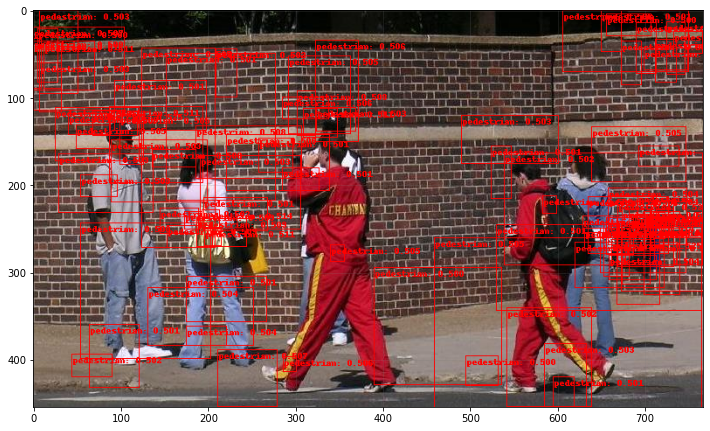

In [25]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from PIL import Image
from torchvision.io import read_image

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

# image = read_image("PennFudanPed/PennFudanPed/PNGImages/FudanPed00002.png")
image = Image.open(r"PennFudanPed/PennFudanPed/PNGImages/PennPed00005.png").convert("RGB")
eval_transform = get_transform(train=False)

model.to(device)
model.eval()
with torch.no_grad():
    target = {}
    x, _ = eval_transform(image, target)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = torchvision.transforms.ToTensor()(image)
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
# image = image[:3, ...]
# pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
# print(pred_labels)
pred_boxes_ = pred["boxes"]
pred_labels_ = pred["labels"]
pred_scores = pred["scores"]
pred_boxes = []
pred_labels = []
for i, box in enumerate(pred_boxes_):
    if pred_scores[i] > 0.5:
        pred_boxes.append(box.tolist())
        pred_labels.append(f"pedestrian: {pred_scores[i]:.3f}")

pred_boxes = torch.tensor(pred_boxes)
print(pred_scores)
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

print(pred["scores"].shape)
print(pred["boxes"])
# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))